# G2Net Gravitational Wave Detection: Creation of CWT transform of the gravitational signal

The very first question that comes to mind is that what are gravitational waves?. The precise and crisp definition of gravitational waves is given in Wikipedia [1](https://en.wikipedia.org/wiki/Gravitational_wave), and it is as follows, 
"***Gravitational waves are disturbances in the curvature of spacetime, generated by accelerated masses, that propagate as waves outward from their source at the speed of light.*** "


In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
# Importing all the training_labels.csv 
df_train_label=pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
df_train_label.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


#### Importing all the address to the files .npy present inside the train folder

In [2]:
# path of the files
paths_files = glob("../input/g2net-gravitational-wave-detection/train/*/*/*/*")

Creating a dataframe path_df, where one column stores the ids and another column holds path to those .npy files

In [3]:
# the ids will store the ids of each of the files
ids=[]
for filext in paths_files:
    ids.append(filext[filext.rindex('/')+1:\
                              len(filext)].replace('.npy',''))
    
# data frame containing paths and ids of .npy files 
path_df = pd.DataFrame({"id":ids,"path":paths_files})
path_df.head()

,id,path
0,777d746e90,../input/g2net-gravitational-wave-detection/tr...
1,777ecfbd65,../input/g2net-gravitational-wave-detection/tr...
2,7770956992,../input/g2net-gravitational-wave-detection/tr...
3,77727f6826,../input/g2net-gravitational-wave-detection/tr...
4,777c84c377,../input/g2net-gravitational-wave-detection/tr...


#### Merging the df_train_label and the path_df dataframes into the df dataframe

In [4]:
df=pd.merge(path_df,df_train_label,on='id')
del path_df, df_train_label;
df.head()

,id,path,target
0,777d746e90,../input/g2net-gravitational-wave-detection/tr...,1
1,777ecfbd65,../input/g2net-gravitational-wave-detection/tr...,0
2,7770956992,../input/g2net-gravitational-wave-detection/tr...,1
3,77727f6826,../input/g2net-gravitational-wave-detection/tr...,1
4,777c84c377,../input/g2net-gravitational-wave-detection/tr...,0


In [5]:
df.shape

(560000, 3)

#### For the purpose of training our model we consider smaller sample of the larger training dataset, therefore we randomly choose 60000 target=1 .npy files and 60000 target=0 .npy files.

In [6]:
df=pd.concat([df[df['target']==1][['id','path','target']].sample(n=60000, random_state=0),\
          df[df['target']==0][['id','path','target']].sample(n=60000, random_state=0)]).sample(frac=1,random_state=0)
df.head()

,id,path,target
77782,bf1eb07f55,../input/g2net-gravitational-wave-detection/tr...,1
172727,5de5b4f546,../input/g2net-gravitational-wave-detection/tr...,0
178138,e298b9db82,../input/g2net-gravitational-wave-detection/tr...,1
443182,4113573643,../input/g2net-gravitational-wave-detection/tr...,0
477845,910a7c72a5,../input/g2net-gravitational-wave-detection/tr...,1


In [7]:
df.shape

(120000, 3)

## Continuous Wavelet Transform of smaller training set 

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

The following piece of code was originally written by Alexander Neergaard Olesen's CWT Python implementation, and reference is given [here](https://github.com/neergaard/CWT). The Keras implementation of the above code was done by Geir Drange. The reference and the functionaluty of the code is given [here](https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer). 

There maybe two question that may have struck your mind,
1. Why not perform Fourier Transform (FT)?.

Ans. Fourier Transform is more suited for stationary waves. It gives complete resolution in frequency but complete uncertainity in time.

2. What is the upper hand of using CWT over FT?.

Ans. CWT is more suited for non stationary waves. The CWT is a multiresolution analysis where we have good time resolution and poor frequency resolution at high frequencies
and good frequency resolution and poor time resolution at low frequencies. 

More detail analysis of FT and CWT has been elegentaly explained in the, "***POLIKAR, ROBI. "The Wavelet Tutorial Second Edition Part I.***" [2](https://web.iitd.ac.in/~sumeet/WaveletTutorial.pdf). The mathematical details of the following code is explained briefly in the following article, "***Torrence, Christopher, and Gilbert P. Compo. "A practical guide to wavelet analysis." Bulletin of the American Meteorological society 79.1 (1998): 61-78.***"

In [9]:
%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License

import tensorflow as tf
from tensorflow import keras
import tensorflow.experimental.numpy as tnp
import numpy as np
import math

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2,\
        'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[\
                                                             np.arange(math.floor((n - 1) / 2),\
                                                                       0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]),\
                           next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(tnp.kron(tf.ones([self.num_scales, 1],\
                                                     dtype=tf.complex64)\
                                             , f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:,\
                                                    self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32),\
                                           tf.zeros([self.batch_size, self.num_scales,\
                                                     inputs.shape[-1]], dtype = tf.float32)))
        return cwt
    
# scale input to range 0.0 - upper
class Scaler(keras.layers.Layer):
    def __init__(self, upper=1.0):
        super(Scaler, self).__init__()
        self.upper = tf.cast(upper, dtype=tf.float32) # upper value (typically 1.0 or 255.0 for image CNNs)
    
    def call(self, inputs):
        min_val = tf.math.reduce_min(inputs)
        max_val = tf.math.reduce_max(tf.math.subtract(inputs, min_val))
        return tf.math.multiply(tf.math.subtract(inputs, min_val), self.upper/max_val)
    
# Stack three channels into RGB image
class RGBStack(keras.layers.Layer):
    def __init__(self):
        super(RGBStack, self).__init__()
        
    def call(self, inputs):
        return tf.stack(inputs, axis = 3)

Writing tf_cwt.py


Importing the customized Keras layers

In [10]:
from tf_cwt import Wavelet1D, Scaler, RGBStack

#### Now we going to load one of the strong gravitational wave signal

In [11]:
# Loading the first .npy data
data=np.load(df[df['target']==1]['path'].iloc[3])
data

array([[-1.41661371e-21, -1.36443280e-21, -1.20573412e-21, ...,
         7.83671606e-22,  8.61849573e-22,  1.41773124e-21],
       [ 9.17605406e-21,  9.05680029e-21,  8.97858006e-21, ...,
         5.69838810e-21,  5.46298374e-21,  5.31875627e-21],
       [-1.52049803e-21, -1.51722241e-21, -1.54984733e-21, ...,
         3.22881317e-22,  4.46477098e-22,  1.80836016e-22]])

#### Following part of the code gives us the visualization how the Number of voices per octave (nv), Low frequency (flow), and High frequency (fhigh) affect the CWT of an input signal. 

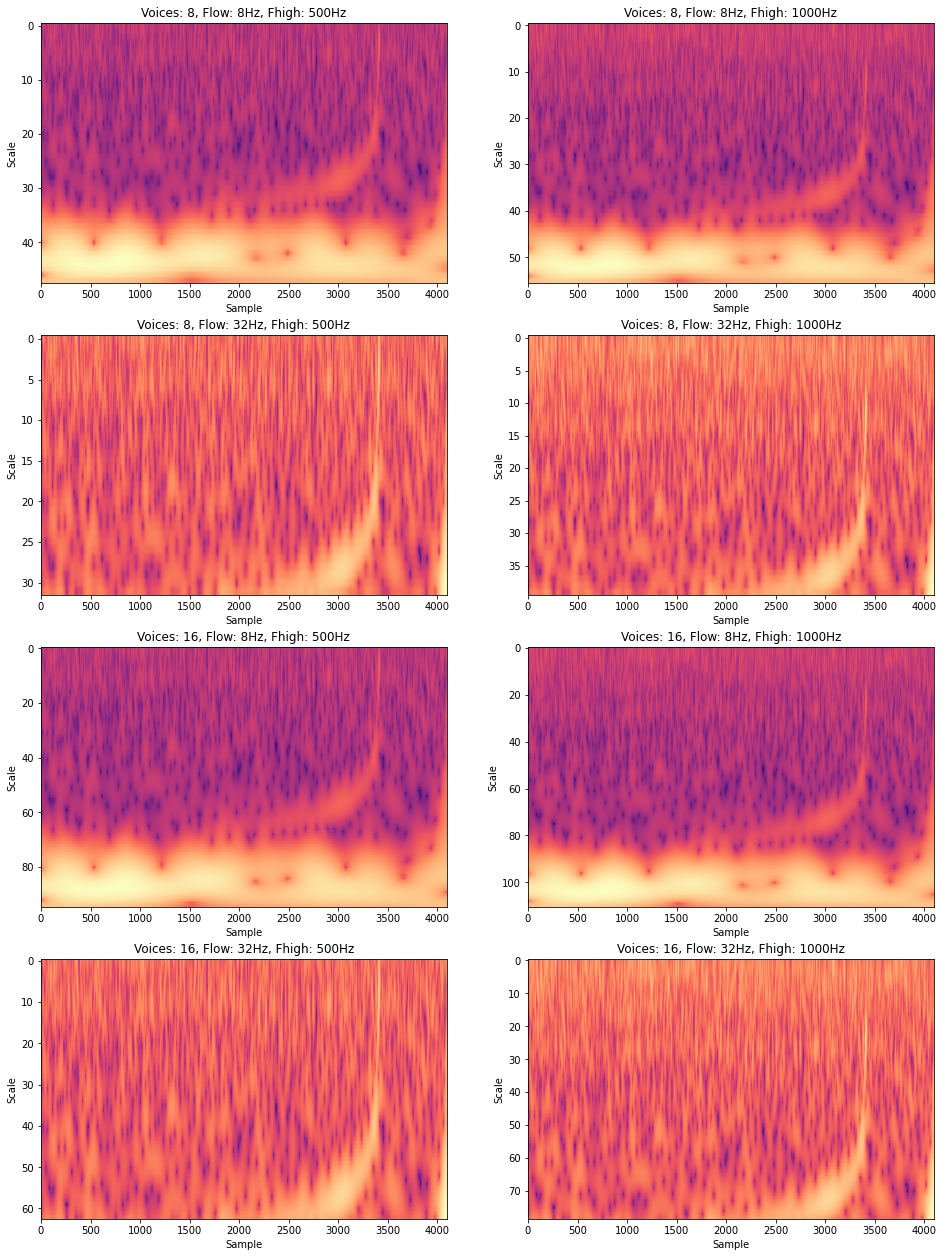

In [13]:
# The following piece of code is taken from  Geir Drange's Notebook and hyperlink is given below,
# https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer
fig = plt.figure(figsize=(16,22))
idx = 0
for nv in [8,16]:
    for flow in [8,32]:
        for fhigh in [500, 1000]:
            y = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=1)\
            (tf.expand_dims(data[0,:], axis=0))
            y = Scaler(upper=1)(y)
            ax = plt.subplot(4, 2, 1+idx)
            plt.xlabel('Sample')
            plt.ylabel('Scale')
            plt.title('Voices: {}, Flow: {}Hz, Fhigh: {}Hz'.format(nv, flow, fhigh))
            plt.imshow(np.squeeze(y.numpy()), cmap='magma', aspect='auto') 
            idx += 1

#### From the above graphs it is quite clear that by setting suitable value for lower frequecy (flow) we can remove the low frequency noise. 

### Downsampling
The scaleogram has the same width as the input signal. This needs to be reduced to our target image size (here we choose 224). Rather than doing an image resize type operation, we can use several types of layers:

1. Max pooling
2. Average pooling
3. 2D convolution (this can also be trained!)
The trick is to set the pool/filter size to (1,n), where n is the reduction factor, and stride to the same size. Let's try it out:

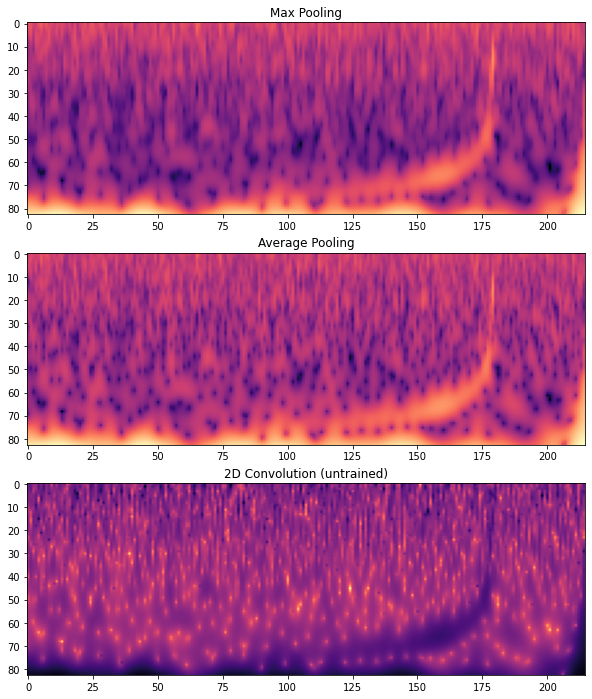

In [14]:
# The following piece of code is taken from  Geir Drange's Notebook and hyperlink is given below,
# https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer
TARGET_IMG_SIZE = 224
STRIDE = int(np.ceil(4096/TARGET_IMG_SIZE))

y1 = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(data[0,:], axis=0))
y1 = Scaler(upper=1)(y1)
y1 = tf.reshape(y1, [y1.shape[0],y1.shape[1],y1.shape[2],1])
fig = plt.figure(figsize=(10,12))
ax = plt.subplot(3, 1, 1)
y2a = MaxPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2a = Scaler(upper=1)(y2a)
plt.title('Max Pooling')
plt.imshow(tf.reshape(y2a, [y2a.shape[1],y2a.shape[2]]).numpy(), cmap='magma', aspect='auto')
ax = plt.subplot(3, 1, 2)
y2b = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2b = Scaler(upper=1)(y2b)
plt.title('Average Pooling')
plt.imshow(tf.reshape(y2b, [y2b.shape[1],y2b.shape[2]]).numpy(), cmap='magma', aspect='auto') 
ax = plt.subplot(3, 1, 3)
y2c = Conv2D(filters=1, kernel_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2c = Scaler(upper=1)(y2c)
plt.title('2D Convolution (untrained)')
plt.imshow(tf.reshape(y2c, [y2c.shape[1],y2c.shape[2]]).numpy(), cmap='magma', aspect='auto');

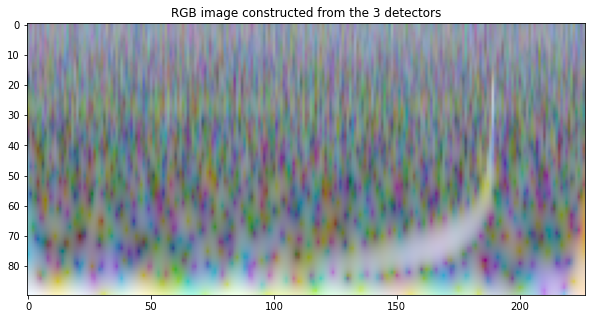

In [16]:
r = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=10000, batch_size=1)(tf.expand_dims(data[0,:], axis=0))
r = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(r, [r.shape[0],r.shape[1],r.shape[2],1]))
r = Scaler(upper=1)(r)
r = tf.reshape(r, [r.shape[1],r.shape[2]])
g = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=10000, batch_size=1)(tf.expand_dims(data[1,:], axis=0))
g = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(g, [g.shape[0],g.shape[1],g.shape[2],1]))
g = Scaler(upper=1)(g)
g = tf.reshape(g, [g.shape[1],g.shape[2]])
b = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=10000, batch_size=1)(tf.expand_dims(data[2,:], axis=0))
b = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(b, [b.shape[0],b.shape[1],b.shape[2],1]))
b = Scaler(upper=1)(b)
b = tf.reshape(b, [b.shape[1],b.shape[2]])
rgb = tf.stack([r, g, b], axis = 2)
fig = plt.figure(figsize=(10,5))
plt.title('RGB image constructed from the 3 detectors')
plt.imshow(rgb.numpy(), cmap='magma', aspect='auto');

#### Combing the output of the 3 detectors into a RBG image as shown below,

**Now we construct a cwt model which perform all the above operation to finally obtain the RBG image.**

In [15]:
# The following piece of code is taken from  Geir Drange's Notebook and hyperlink is given below,
# https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer
TARGET_IMG_SIZE = 224 # image size expected by the CNN model
# skip start to make img_size integer multiple of 4096
OFFSET = 4096-int(np.floor(4096/224))*TARGET_IMG_SIZE
STRIDE = (4096-OFFSET)//TARGET_IMG_SIZE
BATCH_SIZE=20

# CTW model
def build_cwt_model(nv=16, flow=20, fhigh=10000, batch_size=64):
    inputs = Input(shape=(3, 4096))
    # channels
    r = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,0,OFFSET:])  
    g = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,1,OFFSET:]) 
    b = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,2, OFFSET:]) 
    # combine into rgb
    rgb = RGBStack()([r, g, b])
    # downsample
    rgb = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(rgb) 
    rgb = Scaler(upper=255.)(rgb) # adjust 'upper' according to CNN 
    
    return tf.keras.Model(inputs, rgb, name="Wavlet")

cwt_model = build_cwt_model(batch_size=BATCH_SIZE)
cwt_model.summary()

Model: "Wavlet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 4096)]    0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 4032)         0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 4032)         0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 4032)         0           input_1[0][0]                    
_____________________________________________________________________________________________

## Now the question raises how to convert the smaller subset of these .npy files in to the required RGB image of the CWT. In the following section we address the preceding question.

Directly training our model on the .npy files takes a lot of time because loading the data takes a lot of time than performing the ML computations. Mainly the ML computation are done on a GPU, and loading the data task is done by CPU. Former data pipelines made the GPU wait for the CPU to load the data, leading to performance issues [ref.(2)](https://cs230.stanford.edu/blog/datapipeline/). Therefore, the tf.data API enables you to build complex input pipelines from simple, reusable pieces [ref.(4)](https://www.tensorflow.org/guide/data). But this (tf.data) API lack the feature of reading .npy files which doesn't fit in the memory. However, I found a solution in the stackover flow, and link of the solution is given [here](https://stackoverflow.com/questions/48889482/feeding-npy-numpy-files-into-tensorflow-data-pipeline).

In [17]:
def npy_header_offset(npy_path):
    with open(str(npy_path), 'rb') as f:
        if f.read(6) != b'\x93NUMPY':
            raise ValueError('Invalid NPY file.')
        version_major, version_minor = f.read(2)
        if version_major == 1:
            header_len_size = 2
        elif version_major == 2:
            header_len_size = 4
        else:
            raise ValueError('Unknown NPY file version {}.{}.'.format(version_major, version_minor))
        header_len = sum(b << (8 * i) for i, b in enumerate(f.read(header_len_size)))
        header = f.read(header_len)
        if not header.endswith(b'\n'):
            raise ValueError('Invalid NPY file.')
        return f.tell()

In [18]:
header_size = npy_header_offset(df['path'].iloc[0])
header_size

128

Creating two separate directories to store the RBG images for the .npy files with target=1 in the target1 folder, and for the .npy files with target=0 in the target0 folder 

In [19]:
os.makedirs('./target0',exist_ok=True)
os.makedirs('./target1',exist_ok=True)

In [21]:
df[df['target']==1]['path'].iloc[59000:60000].tail()

267556    ../input/g2net-gravitational-wave-detection/tr...
165792    ../input/g2net-gravitational-wave-detection/tr...
391985    ../input/g2net-gravitational-wave-detection/tr...
66205     ../input/g2net-gravitational-wave-detection/tr...
327282    ../input/g2net-gravitational-wave-detection/tr...
Name: path, dtype: object

In [ ]:
#import time
count=0
for i in range(0,int(len(df)/2),1000):    
    #start=time.perf_counter()
    # Importing those .npy files which has target=1
    tf_target1=tf.data.FixedLengthRecordDataset( df[df['target']==1]['path'].iloc[i:i+1000],\
                                                   3*4096*tf.float64.size,\
                                             header_bytes=header_size,\
                                                num_parallel_reads=BATCH_SIZE)
    tf_target1 = tf_target1.map(lambda s: tf.reshape(\
                                                           tf.io.decode_raw(s, tf.float64),\
                                                           (3,4096)))
    # Importing those .npy files which has target=0
    tf_target0=tf.data.FixedLengthRecordDataset( df[df['target']==0]['path'].iloc[i:i+1000],\
                                                   3*4096*tf.float64.size,\
                                             header_bytes=header_size,\
                                                num_parallel_reads=BATCH_SIZE)
    tf_target0 = tf_target0.map(lambda s: tf.reshape(\
                                                           tf.io.decode_raw(s, tf.float64),\
                                                           (3,4096)))
    target1 = tf_target1.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    target0 = tf_target0.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    # It will store the RBG images for target=1 images
    data=cwt_model.predict(target1)
    for ii in range(0,data.shape[0]):
    #    start=time.perf_counter()
        # Saving the images
        img = Image.fromarray(data[ii,:,:,:].reshape(90,224,3).astype(np.uint8))
        img.save(f'./target1/target1_pic{(ii+1+count)}.png')
    #    finish=time.perf_counter()
    #    print("Creating each file time = ",finish-start)
    # It will store the RBG images for target=0 images
    data=cwt_model.predict(target0)
    for ii in range(0,data.shape[0]):
        #start=time.perf_counter()
        # Saving the images
        img = Image.fromarray(data[ii,:,:,:].reshape(90,224,3).astype(np.uint8))
        img.save(f'./target0/target0_pic{(ii+1+count)}.png')
        #finish=time.perf_counter()
    #print("Predict time = ",finish-start)
    count=count+1000

#### The above code runs above 4-5 hrs in GPU settings.